#### Train a single network on MNIST 0-4, then transfer to MNIST 5-9

In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
from copy import deepcopy
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from data_handler import DataHandler 
from IPython import display

In [4]:
# import class Model
# from model import Model
from model2 import Model

In [5]:
# mnist imshow convenience function
# input is a 1D array of length 784
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

# return a new mnist dataset w/ pixels randomly permuted
def permute_mnist(mnist):
    perm_inds = range(mnist.train.images.shape[1])
    np.random.shuffle(perm_inds)
    mnist2 = deepcopy(mnist)
    sets = ["train", "validation", "test"]
    for set_name in sets:
        this_set = getattr(mnist2, set_name) # shallow copy
        this_set._images = np.transpose(np.array([this_set.images[:,c] for c in perm_inds]))
    return mnist2

In [6]:
# classification accuracy plotting
def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0,1)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
# train/compare vanilla sgd and ewc
def train_task(model, num_iter, disp_freq, trainset, testsets, x, y_, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore(sess) # reassign optimal weights from previous training session
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter/disp_freq))
        # train on current task
        for iter in range(num_iter):
            batch_size = 128 
            batch = trainset.train.next_batch(batch_size)
            model.train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets)):
                    feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    test_accs[task][iter/disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter/disp_freq+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                if l == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)

In [7]:
def train_task2(model, num_iter, disp_freq, trainset, testsets, x, y_, lams=[0]):
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore(sess) # reassign optimal weights from previous training session
        
#         if(lams[l] == 0):
#             model.set_vanilla_loss()
#         else:
#             model.update_ewc_loss(lams[l])
            
        if(l == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
            
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets)):
            test_accs.append(np.zeros(num_iter/disp_freq))
            
        # train on current task
        total_loss = 0.0 
        task_loss = [] 
        with sess.as_default(): 
#             sess.run(tf.global_variables_initializer())
            for iter in range(num_iter):
                batch_size = 128 
                batch = trainset.train.next_batch(batch_size)
                
                if(l == 0):
                    loss = model.cross_entropy 
                else:
                    loss = model.ewc_loss
                
                _, loss_batch = sess.run([model.train_step, loss],feed_dict=
                                         {x: batch[0], y_: batch[1], model.phase: 1, model.dropout: 0.75})
                total_loss += loss_batch 
    #             model.train_step.run(feed_dict={x: batch[0], y_: batch[1], model.phase: 1, model.dropout: 0.75})
#                 sess.run(model.train_step,feed_dict={x: batch[0], y_: batch[1], model.phase: 1, model.dropout: 0.75})
                
                if iter % disp_freq == 0:
                    plt.subplot(1, len(lams), l+1)
                    plots = []
                    colors = ['r', 'b', 'g']
                    for task in range(len(testsets)):
                        feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels, model.phase: 0, model.dropout: 0.75}
                        test_accs[task][iter/disp_freq] = model.accuracy.eval(feed_dict=feed_dict)
                        c = chr(ord('A') + task)
                        plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:iter/disp_freq+1], colors[task], label="task " + c)
                        plots.append(plot_h)
                    plot_test_acc(plots)
                    if l == 0: 
                        plt.title("vanilla sgd")
                    else:
                        plt.title("ewc")
                    plt.gcf().set_size_inches(len(lams)*5, 3.5)
                
                    task_loss.append(total_loss)
                    total_loss = 0.0 
            
            for iter in range(num_iter): 
                if iter % disp_freq == 0: 
                    # print loss
                    print('Average loss at step {}: {:5.1f}'.format(iter + 1, total_loss/disp_freq))

In [8]:
def compute_fisher(imgset, sess, num_samples=200, plot_diffs=False, disp_freq=10):
    model.F_accum = []
    for v in range(len(model.var_list)):
        model.F_accum.append(np.zeros(model.var_list[v].get_shape().as_list()))

    # sampling a random class from softmax
    probs = tf.nn.softmax(model.y)
    class_ind = tf.to_int32(tf.multinomial(tf.log(probs), 1)[0][0])

    if(plot_diffs):
        # track differences in mean Fisher info
        F_prev = deepcopy(model.F_accum)
        mean_diffs = np.zeros(0)

    for i in range(num_samples):
        # select random input image
        im_ind = np.random.randint(imgset.images.shape[0])

        # compute first-order derivatives
        feed_dict={
            # self.y: imgset.labels[im_ind:im_ind + 1],
            model.x: imgset.images[im_ind:im_ind + 1], 
            model.phase: 1, 
            model.dropout: 0.75}

        log_likelihood = tf.log(probs[0,class_ind])
        # gradients = self.compute_gradients(log_likelihood, self.var_list) 
        gradients = tf.gradients(log_likelihood, model.var_list)
        
        
        for var, grad in zip(model.var_list, gradients):
            if grad is None: 
                print(var)
                print(var.eval())
                print(grad)
                model.var_list.remove(var)
                gradients.remove(grad)
        
        ders = sess.run(gradients, feed_dict=feed_dict)

        # square the derivatives and add to total
        for v in range(len(model.F_accum)):
            model.F_accum[v] += np.square(ders[v])
        if(plot_diffs):
            if i % disp_freq == 0 and i > 0:
                # recording mean diffs of F
                F_diff = 0
                for v in range(len(model.F_accum)):
                    F_diff += np.sum(np.absolute(model.F_accum[v]/(i+1) - F_prev[v]))
                mean_diff = np.mean(F_diff)
                mean_diffs = np.append(mean_diffs, mean_diff)
                for v in range(len(model.F_accum)):
                    F_prev[v] = model.F_accum[v]/(i+1)
                plt.plot(range(disp_freq+1, i+2, disp_freq), mean_diffs)
                plt.xlabel("Number of samples")
                plt.ylabel("Mean absolute Fisher difference")
                display.display(plt.gcf())
                display.clear_output(wait=True)

    # divide totals by number of samples
    for v in range(len(model.F_accum)):
        model.F_accum[v] /= num_samples


In [9]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
# print(mnist.train.images.shape)
# data_handler = DataHandler('mnist')
# mnist, mnist2 = data_handler.split_dataset(validation_size=3000)
# print(mnist.train.images.shape)
# print(mnist2.train.images.shape)
# test = 10
# mnist_imshow(mnist.train.images[test])
# print(mnist.train.labels[test])


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [10]:
sess = tf.InteractiveSession()
# sess = tf.Session() 

In [11]:
# define input and target placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [12]:
# instantiate new model
model = Model(x, y_) # simple 2-layer network
# print(model.var_list)
# print(tf.trainable_variables())

Completed constructing graph of SimpleCNN.
Here!!
Defined loss and opitimization function.


In [13]:
# initialize variables
sess.run(tf.global_variables_initializer())
# tf.global_variables_initializer().run()
# sess.run(tf.initialize_all_variables())
# print(model.var_list)
# count = 0 
# for param in model.var_list: 
#     if(param.eval().any() == 0):
#         count += 1
#         print(param)
#         print(param.eval())
# print(count)

#### train on task A, test on task A

Average loss at step 1:   0.7
Average loss at step 21:   0.7
Average loss at step 41:   0.7
Average loss at step 61:   0.7
Average loss at step 81:   0.7
Average loss at step 101:   0.7
Average loss at step 121:   0.7
Average loss at step 141:   0.7
Average loss at step 161:   0.7
Average loss at step 181:   0.7
Average loss at step 201:   0.7
Average loss at step 221:   0.7
Average loss at step 241:   0.7
Average loss at step 261:   0.7
Average loss at step 281:   0.7
Average loss at step 301:   0.7
Average loss at step 321:   0.7
Average loss at step 341:   0.7
Average loss at step 361:   0.7
Average loss at step 381:   0.7
Average loss at step 401:   0.7
Average loss at step 421:   0.7
Average loss at step 441:   0.7
Average loss at step 461:   0.7
Average loss at step 481:   0.7
Average loss at step 501:   0.7
Average loss at step 521:   0.7
Average loss at step 541:   0.7
Average loss at step 561:   0.7
Average loss at step 581:   0.7
Average loss at step 601:   0.7
Average loss a

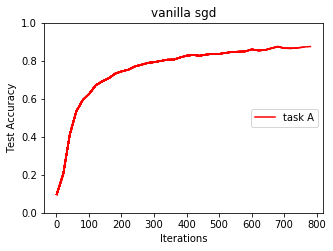

In [14]:
# training 1st task
train_task2(model, 800, 20, mnist, [mnist], x, y_, lams=[0])

In [15]:
# Check for zero variable 
print(model.var_list)
count = 0 
for param in model.var_list: 
    if(param.eval().any() == 0):
        count += 1
        print(param)
        print(param.eval())
        model.var_list.remove(param)
print(count)


[<tf.Variable 'conv1/kernels:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'conv1/biases:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv1/batch_norm/gamma:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv1/batch_norm/beta:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'conv2/kernels:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'conv2/biases:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv2/batch_norm/gamma:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'conv2/batch_norm/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'fc1/weights:0' shape=(3136, 1024) dtype=float32_ref>, <tf.Variable 'fc1/biases:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'softmax_linear/weights:0' shape=(1024, 10) dtype=float32_ref>, <tf.Variable 'softmax_linear/biases:0' shape=(10,) dtype=float32_ref>]
0


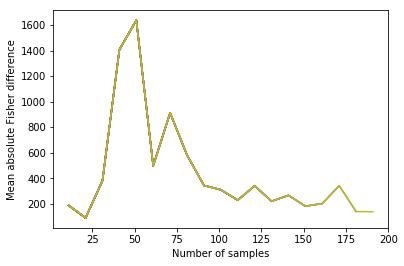

In [15]:
# compute_fisher(mnist.validation, sess, num_samples=200, plot_diffs=True) # use validation set for Fisher computation
model.compute_fisher(mnist.validation, sess, num_samples=200, plot_diffs=True) # use validation set for Fisher computation

In [17]:
# print(model.star_vars[0])
# print(model.var_list[0].eval())
print(len(model.var_list))
test = tf.reduce_sum(tf.multiply(model.F_accum[1].astype(np.float32),tf.square(model.var_list[1] - model.star_vars[1])))
print(test.eval())
# F_row_mean = np.mean(model.F_accum[0], 1)
# mnist_imshow(F_row_mean)
# plt.title("W1 row-wise mean Fisher");

12


AttributeError: Model instance has no attribute 'star_vars'

#### train on task B, test on tasks A and B

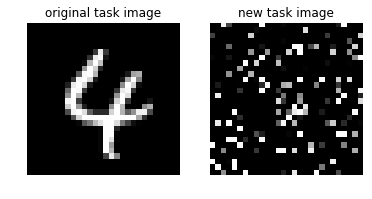

In [17]:
# permuting mnist for 2nd task
mnist2 = permute_mnist(mnist)

plt.subplot(1,2,1)
mnist_imshow(mnist.train.images[5])
plt.title("original task image")
plt.subplot(1,2,2)
mnist_imshow(mnist2.train.images[5])
plt.title("new task image");

In [18]:
# save current optimal weights
model.star()

Average loss at step 1:   1.4
Average loss at step 21:   1.4
Average loss at step 41:   1.4
Average loss at step 61:   1.4
Average loss at step 81:   1.4
Average loss at step 101:   1.4
Average loss at step 121:   1.4
Average loss at step 141:   1.4
Average loss at step 161:   1.4
Average loss at step 181:   1.4
Average loss at step 201:   1.4
Average loss at step 221:   1.4
Average loss at step 241:   1.4
Average loss at step 261:   1.4
Average loss at step 281:   1.4
Average loss at step 301:   1.4
Average loss at step 321:   1.4
Average loss at step 341:   1.4
Average loss at step 361:   1.4
Average loss at step 381:   1.4
Average loss at step 401:   1.4
Average loss at step 421:   1.4
Average loss at step 441:   1.4
Average loss at step 461:   1.4
Average loss at step 481:   1.4
Average loss at step 501:   1.4
Average loss at step 521:   1.4
Average loss at step 541:   1.4
Average loss at step 561:   1.4
Average loss at step 581:   1.4
Average loss at step 601:   1.4
Average loss a

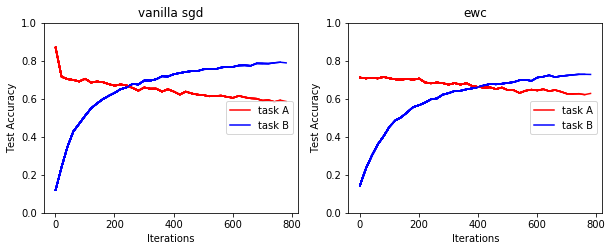

In [19]:
# training 2nd task
train_task2(model, 800, 20, mnist2, [mnist, mnist2], x, y_, lams=[0, 15])

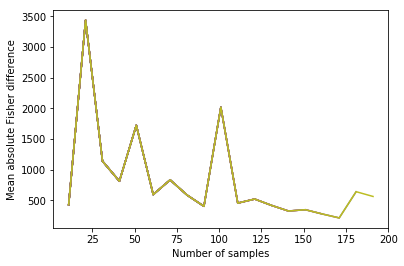

In [21]:
# Fisher information for 2nd task
model.compute_fisher(mnist2.validation, sess, num_samples=200, plot_diffs=True)

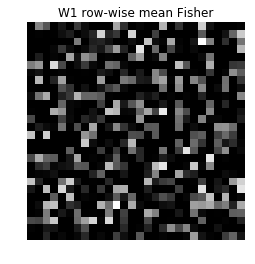

In [22]:
F_row_mean = np.mean(model.F_accum[0], 1)
mnist_imshow(F_row_mean)
plt.title("W1 row-wise mean Fisher");

#### train on task C, test on tasks A, B, and C

In [22]:
# permuting mnist for 3rd task
mnist3 = permute_mnist(mnist)

In [23]:
# save current optimal weights
model.star()

Average loss at step 1:   1.5
Average loss at step 21:   1.5
Average loss at step 41:   1.5
Average loss at step 61:   1.5
Average loss at step 81:   1.5
Average loss at step 101:   1.5
Average loss at step 121:   1.5
Average loss at step 141:   1.5
Average loss at step 161:   1.5
Average loss at step 181:   1.5
Average loss at step 201:   1.5
Average loss at step 221:   1.5
Average loss at step 241:   1.5
Average loss at step 261:   1.5
Average loss at step 281:   1.5
Average loss at step 301:   1.5
Average loss at step 321:   1.5
Average loss at step 341:   1.5
Average loss at step 361:   1.5
Average loss at step 381:   1.5
Average loss at step 401:   1.5
Average loss at step 421:   1.5
Average loss at step 441:   1.5
Average loss at step 461:   1.5
Average loss at step 481:   1.5
Average loss at step 501:   1.5
Average loss at step 521:   1.5
Average loss at step 541:   1.5
Average loss at step 561:   1.5
Average loss at step 581:   1.5
Average loss at step 601:   1.5
Average loss a

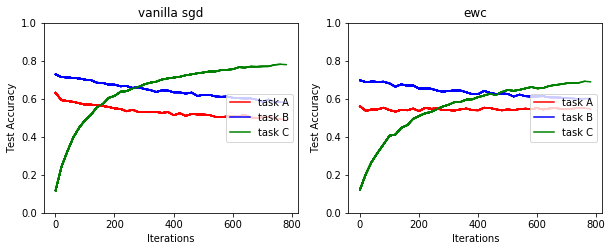

In [25]:
# training 3rd task
train_task2(model, 800, 20, mnist3, [mnist, mnist2, mnist3], x, y_, lams=[0, 15])